In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [32]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator

In [8]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build a neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
        )
        
        
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size,
                                   stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels=input_channels, out_channels=output_channels, kernel_size=kernel_size,
                                  stride=stride),
                nn.Tanh(),
            )
        
    def unsqueeze_noise(self, noise):
        
        # A noise tensor input with dimensions (n_samples, z_dim)
        
        return noise.view(len(noise), self.z_dim, 1, 1)
    
    def forward(self, noise):
        
        x = self.unsqueeze_noise(noise)
        return self.gen(x)
    
def get_noise(n_samples, z_dim, device='cpu'):
    
    return torch.randn(n_samples, z_dim, device=device)

In [13]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_final_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

gen_output.shape

torch.Size([100, 1, 28, 28])

In [10]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")


Success!


### Discriminator

In [19]:
class Discriminator(nn.Module):
    
    def __init__(self, im_chan=1, hidden_dim=16):
        
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True)
        )
        
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        
        if not final_layer:
            
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        
        else:
            
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                #nn.LeakyReLU(0.2, inplace=True)
            )
        
    def forward(self, image):
        
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [20]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
'''
Test your make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

In [21]:
try:
    # Test the hidden block
    assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
    # Because of the LeakyReLU slope
    assert -hidden_output.min() / hidden_output.max() > 0.15
    assert -hidden_output.min() / hidden_output.max() < 0.25
    assert hidden_output.std() > 0.5
    assert hidden_output.std() < 1

    # Test the final block

    assert tuple(final_output.shape) == (num_test, 10, 6, 6)
    assert final_output.max() > 1.0
    assert final_output.min() < -1.0
    assert final_output.std() > 0.3
    assert final_output.std() < 0.6

    # Test the whole thing:

    assert tuple(disc_output.shape) == (num_test, 1)
    assert disc_output.std() > 0.25
    assert disc_output.std() < 0.5
    print("Success!")
except:
    print("Some of asserts have fail")

Success!


### Training

In [24]:
# Loss function
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
batch_size = 128
display_step = 500
lr = 0.0002

# Parameters for adam
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# We can transform the range of the values between -1 and 1 (as tanh activation function)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

dataloader = DataLoader(
    MNIST('dataset/', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

In [29]:
# Initializing our generators, discriminators and optimizers
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the noraml distribution 
# ... with mean 0 and std of 0.02
def weights_init(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 2.2928234902620326, discriminator loss: 0.14975749919563527


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 2.5168377188444135, discriminator loss: 0.20020059467107051


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.8146103821247823, discriminator loss: 0.34455840206146254


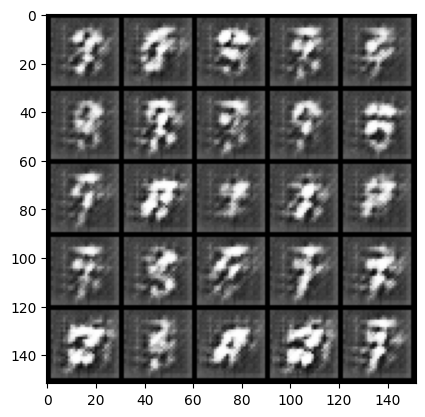

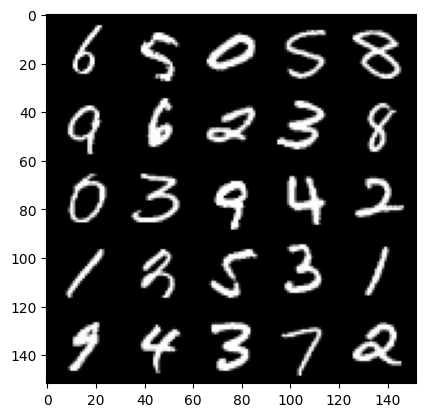

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.3529774801731098, discriminator loss: 0.4580250959396364


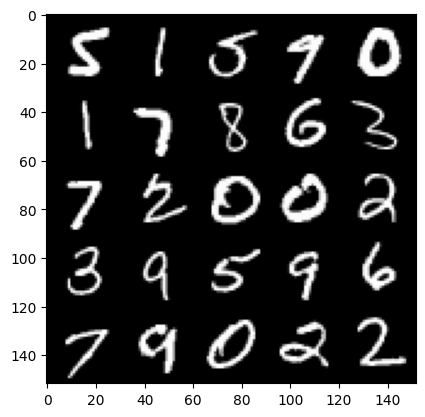

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.04173635095358, discriminator loss: 0.5303987440466883


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.9458662612438207, discriminator loss: 0.5752520108222956


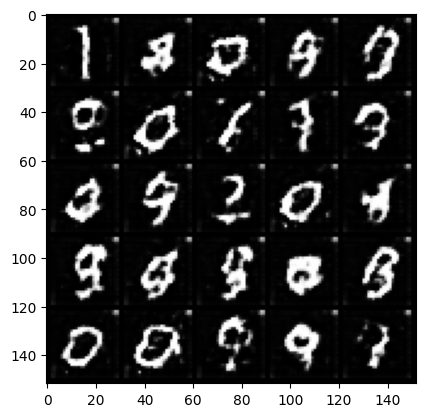

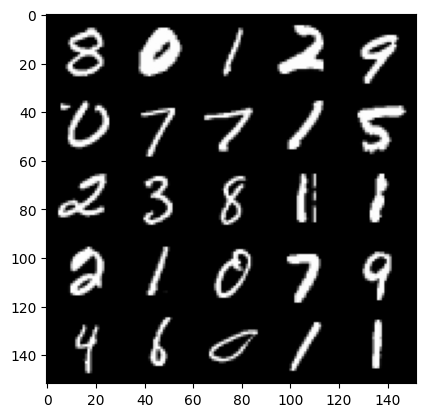

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8702731312513343, discriminator loss: 0.6050422701835625


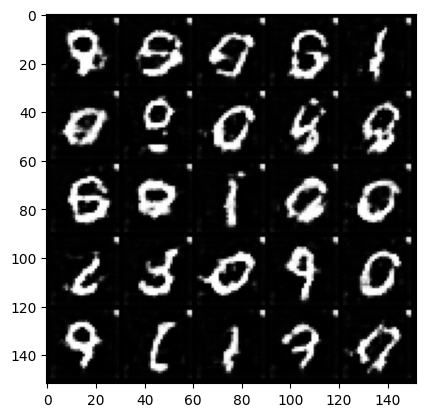

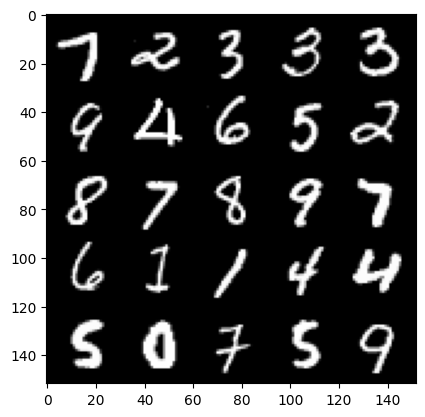

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.8684421756267547, discriminator loss: 0.6199146690368651


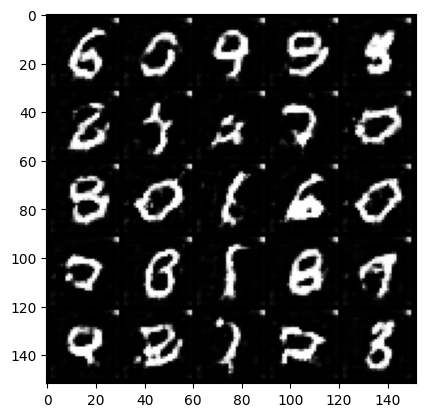

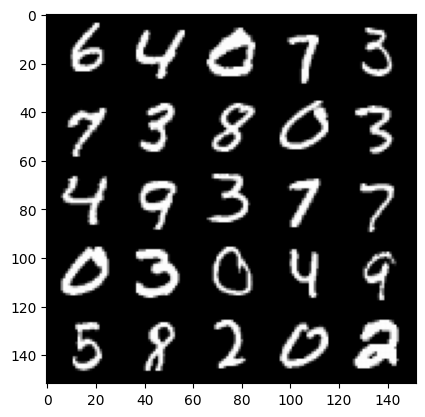

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.8495324995517733, discriminator loss: 0.6298153749704362


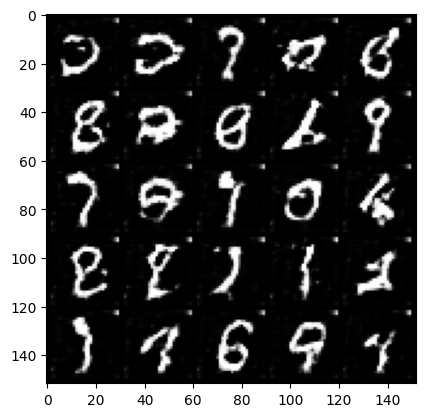

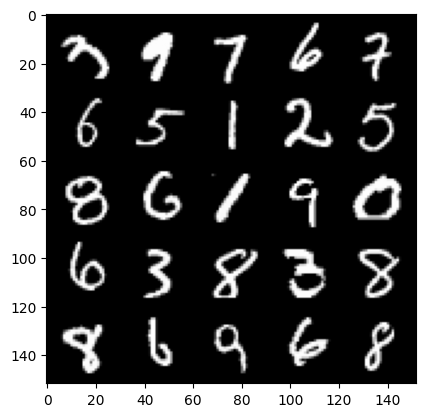

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.8472748205065729, discriminator loss: 0.6319364788532255


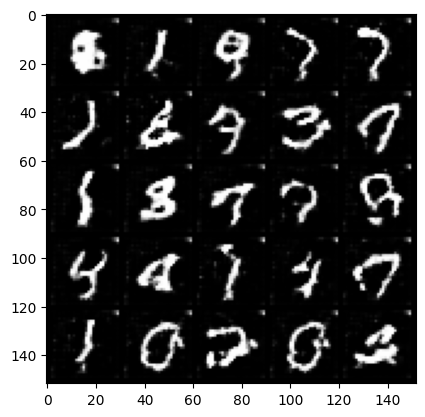

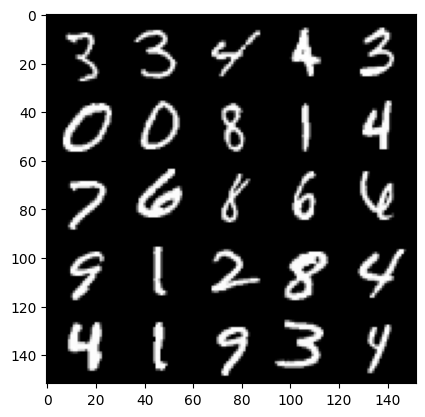

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.833516669273377, discriminator loss: 0.6398755024671555


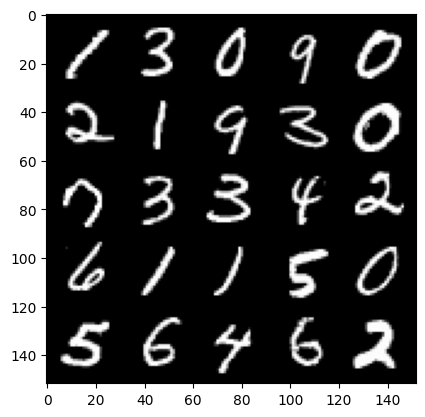

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.8201833318471915, discriminator loss: 0.648048844575882


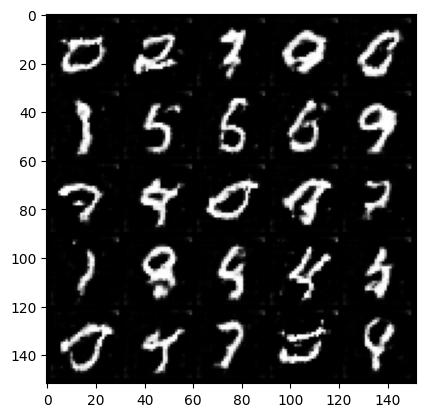

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7961861290931694, discriminator loss: 0.6589617096185683


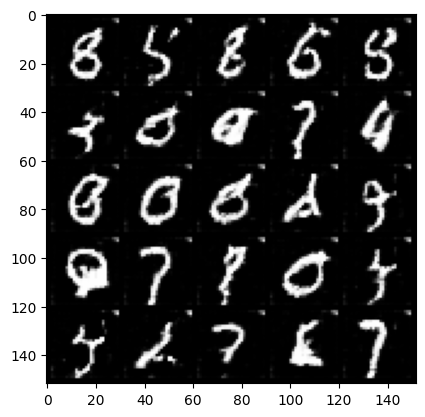

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7754141583442677, discriminator loss: 0.6676794334650039


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7653066219687467, discriminator loss: 0.6727847019433978


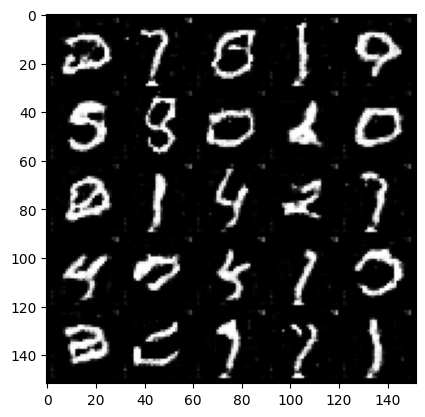

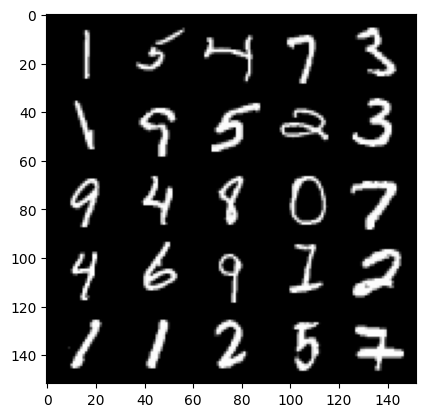

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7553324986696248, discriminator loss: 0.6765604778528217


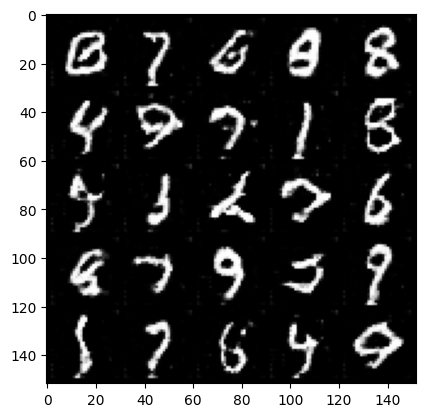

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7500472679734215, discriminator loss: 0.6798736579418183


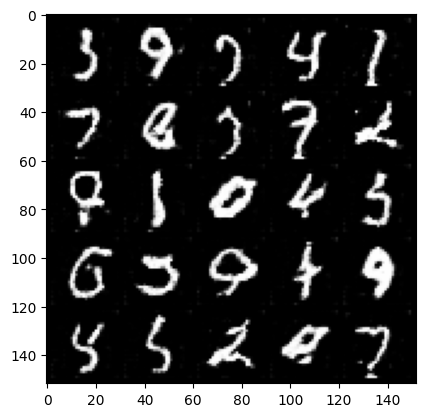

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7462539267539983, discriminator loss: 0.6839923338890073


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7463255848884577, discriminator loss: 0.68498205256462


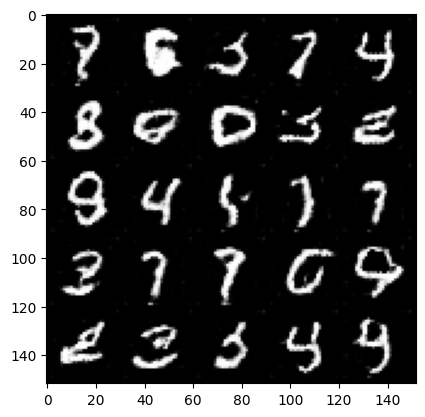

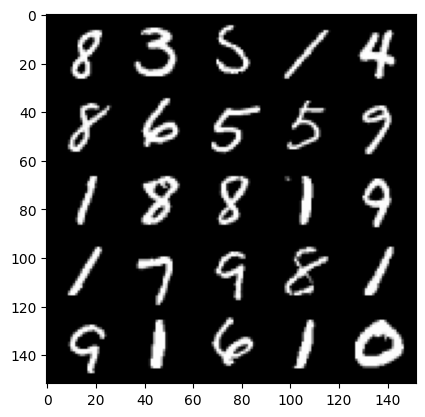

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7363227609395981, discriminator loss: 0.6885840027332303


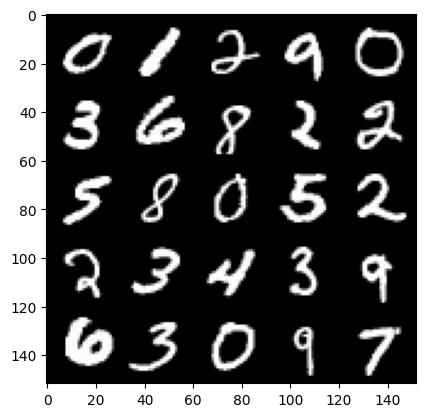

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7321937087774277, discriminator loss: 0.691087092399597


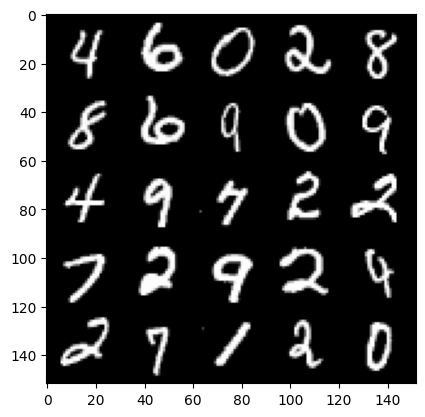

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7289973128437988, discriminator loss: 0.6921989127397533


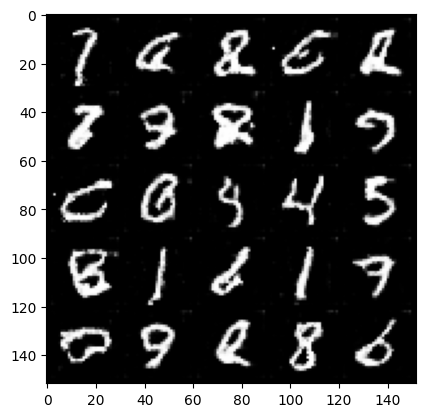

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7266391736268993, discriminator loss: 0.6923930736780167


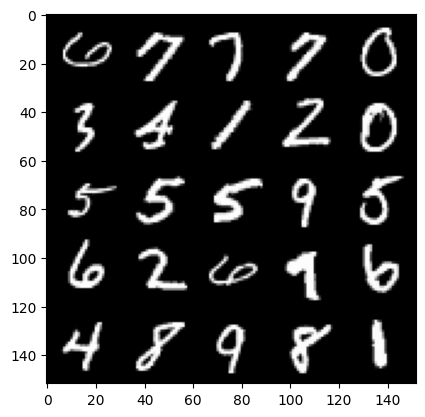

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.725162998557091, discriminator loss: 0.6947220844030387


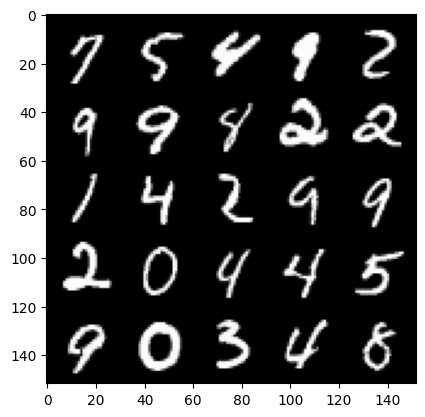

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7210313513875006, discriminator loss: 0.6958064733743681


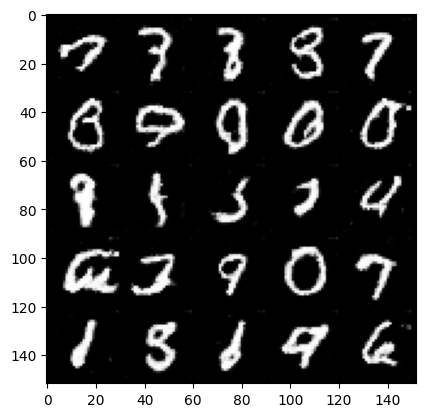

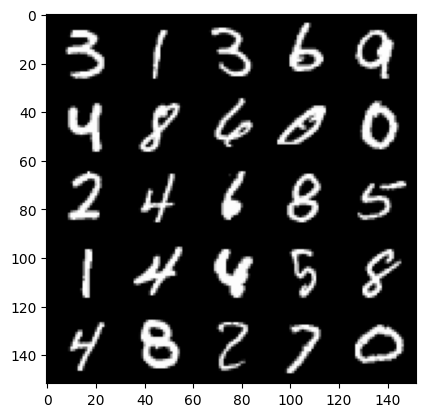

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.719054923117161, discriminator loss: 0.6957331446409214


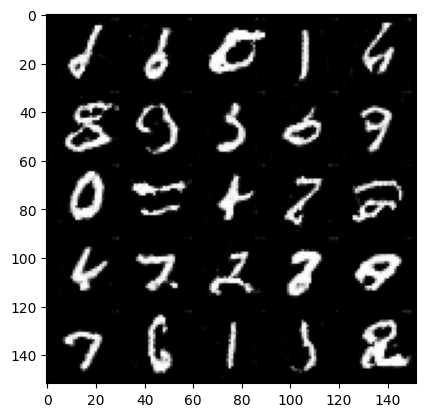

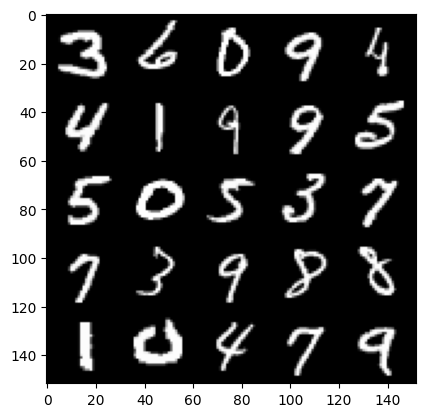

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7195634112358097, discriminator loss: 0.6972712490558629


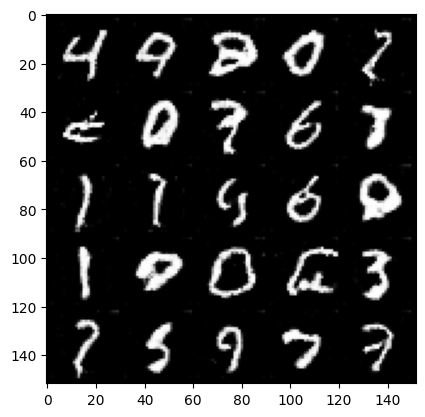

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7144135436415677, discriminator loss: 0.6969388216733945


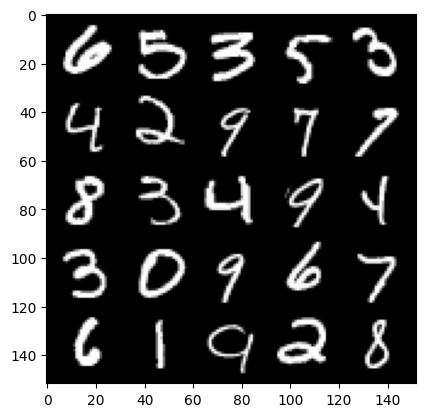

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.7140771549344058, discriminator loss: 0.6973659588098522


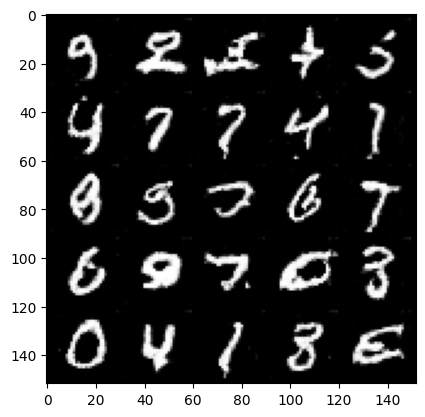

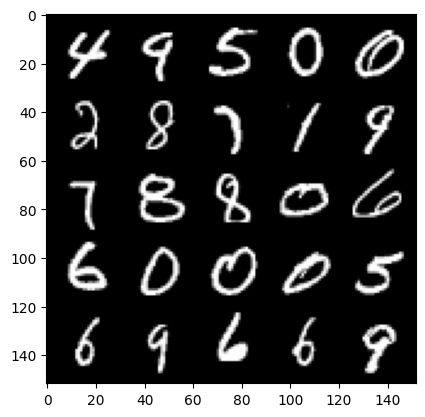

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.7105391302704804, discriminator loss: 0.6975063210725784


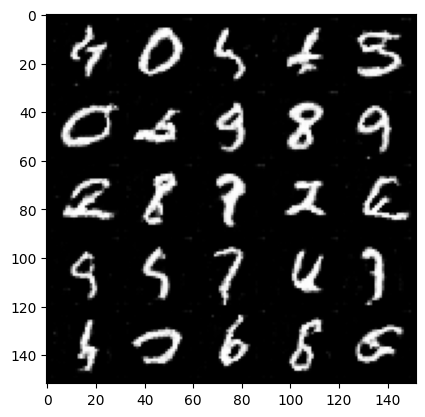

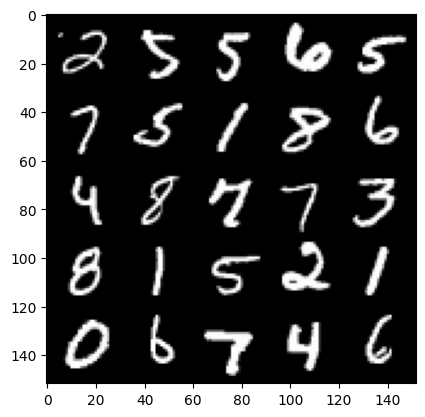

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7090699968934052, discriminator loss: 0.6992228634357456


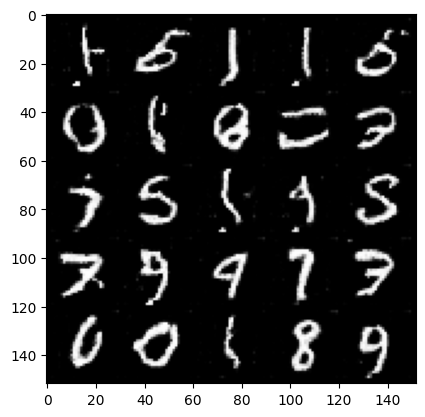

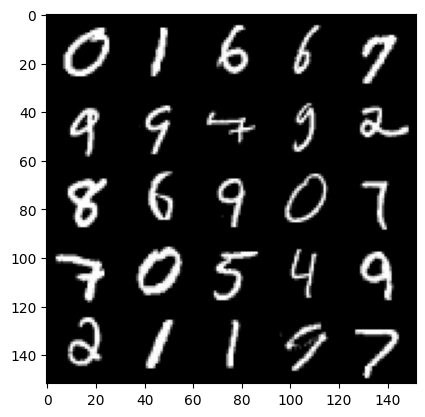

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.7078250077962881, discriminator loss: 0.6991436141729361


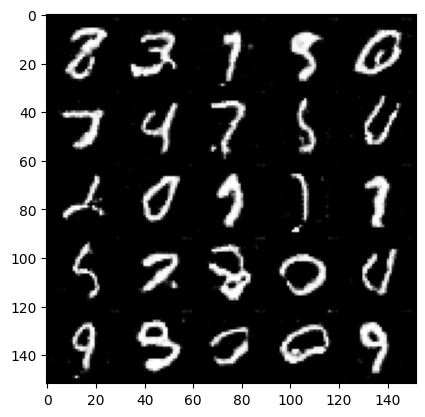

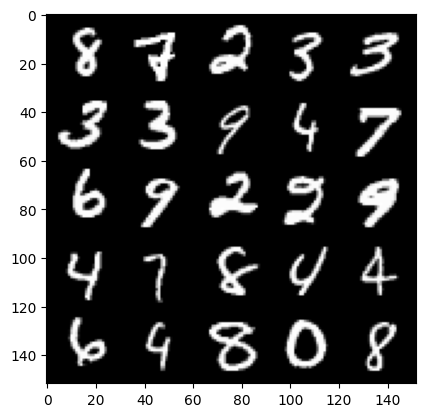

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.7064205993413921, discriminator loss: 0.6985437788963313


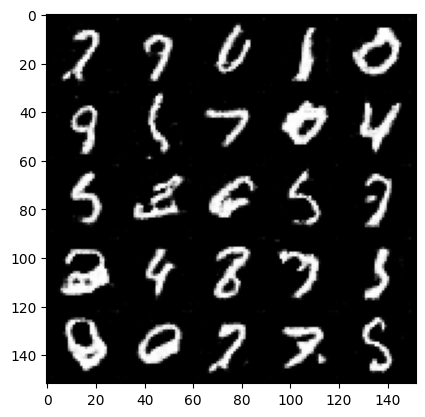

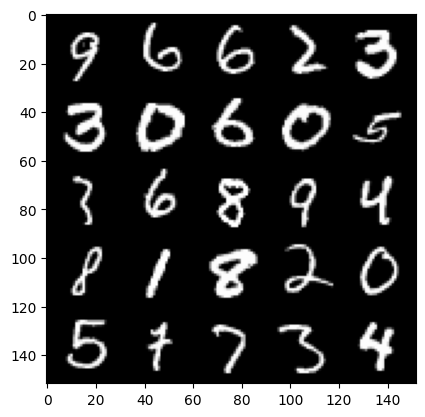

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.7055131521224973, discriminator loss: 0.6982660483121875


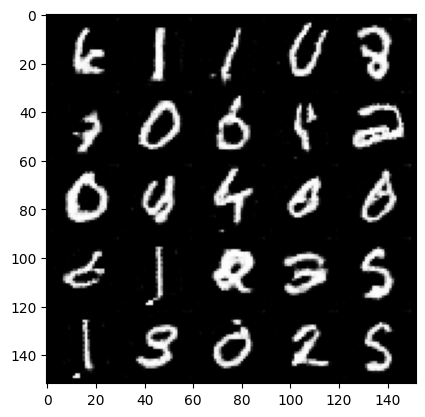

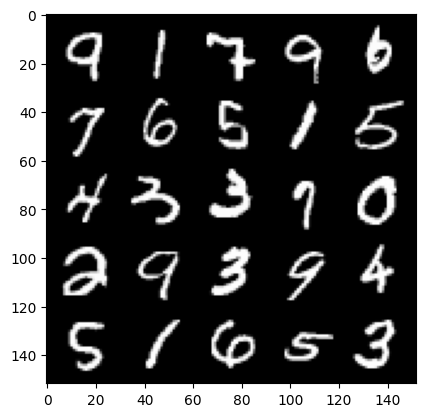

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.7043762293457989, discriminator loss: 0.6989686031341549


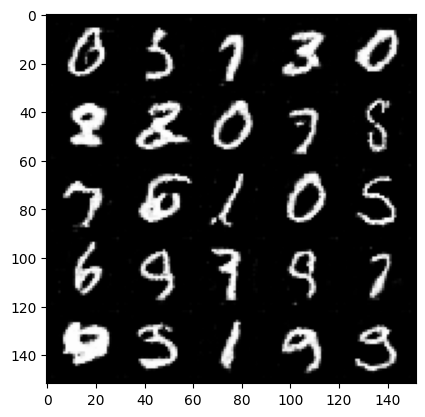

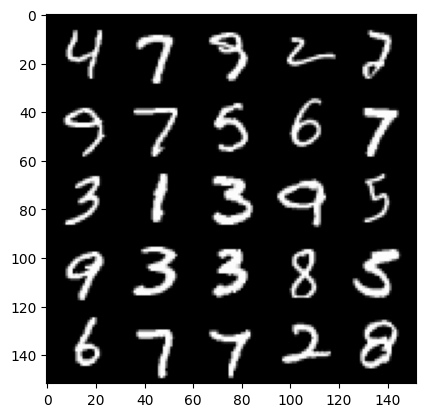

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.7051502809524535, discriminator loss: 0.6983233103752128


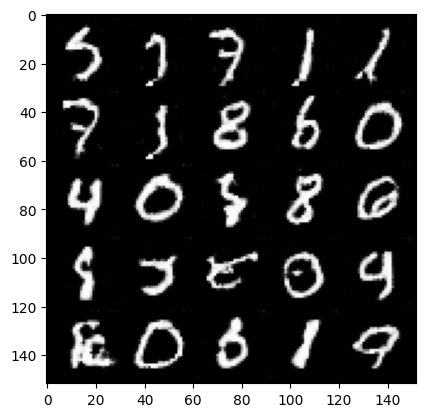

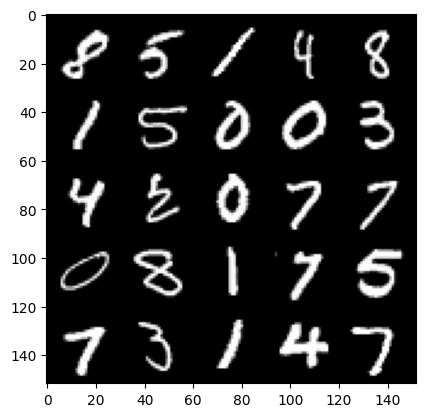

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.7035367181301108, discriminator loss: 0.6979373812675476


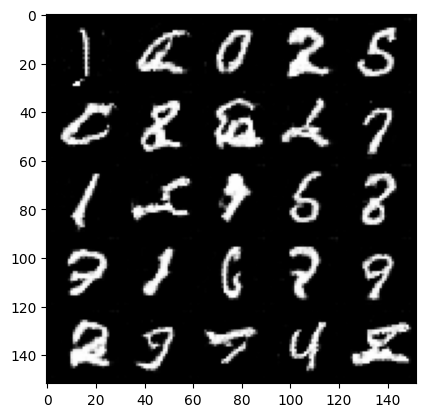

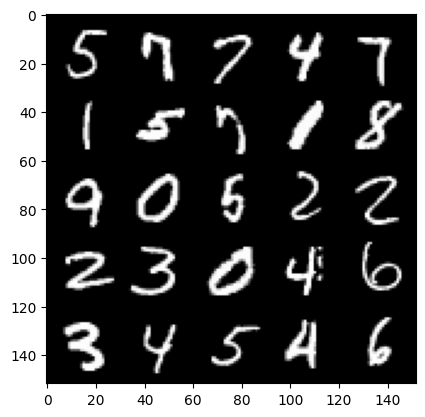

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.7048214692473417, discriminator loss: 0.6978599188327781


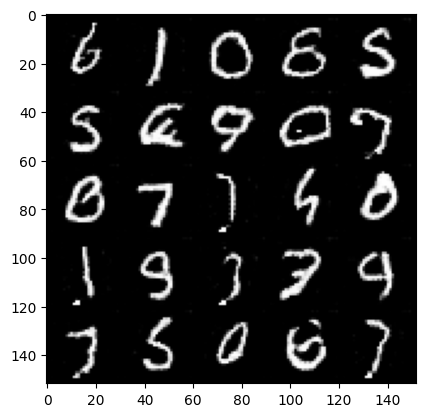

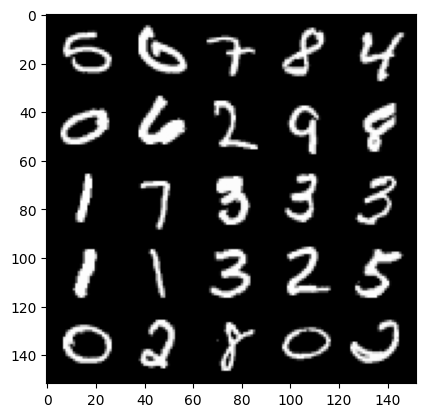

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.7039298654198652, discriminator loss: 0.6977159628868105


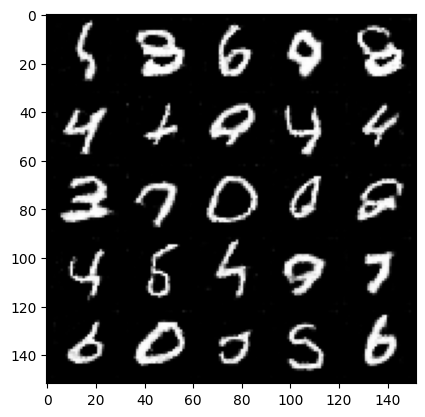

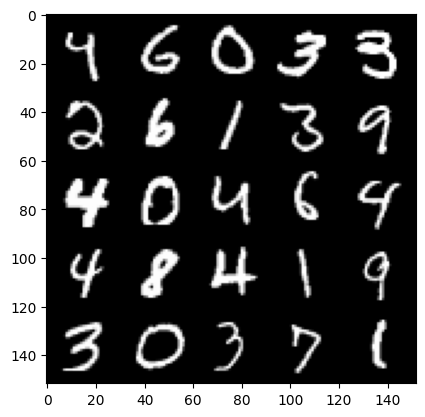

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.7025576927661891, discriminator loss: 0.6980975750684737


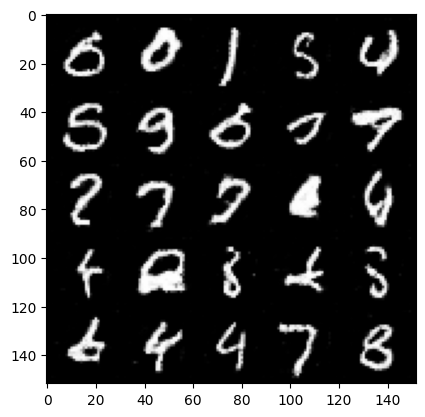

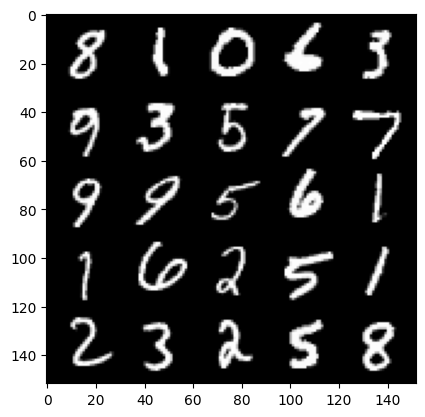

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.701853795051575, discriminator loss: 0.6977851930856711


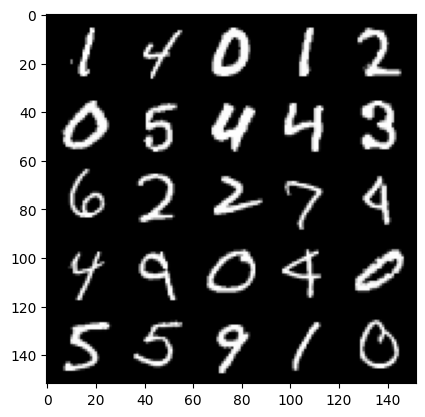

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.7026838268041609, discriminator loss: 0.697602226734161


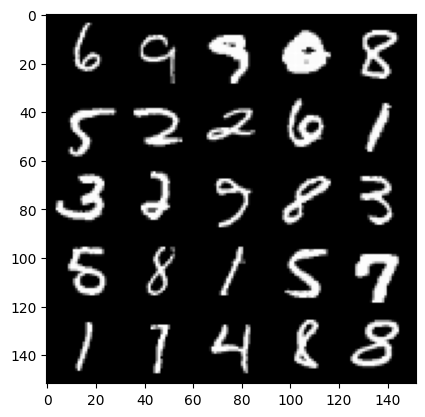

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.700575739860535, discriminator loss: 0.6972689498662945


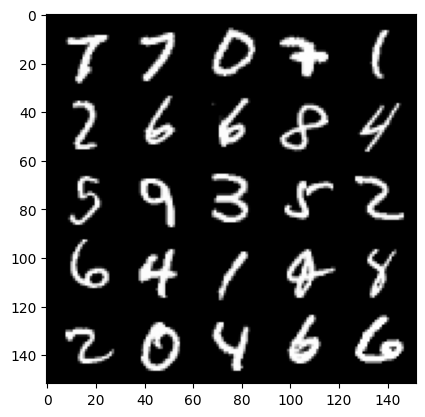

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.7006863476037982, discriminator loss: 0.6969993041753763


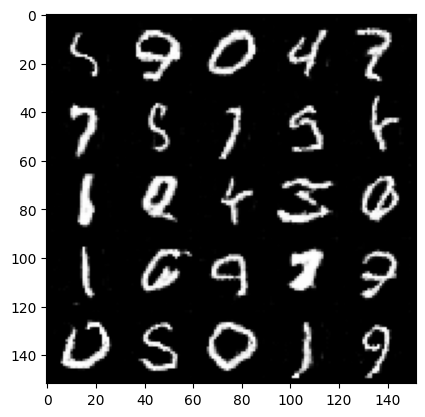

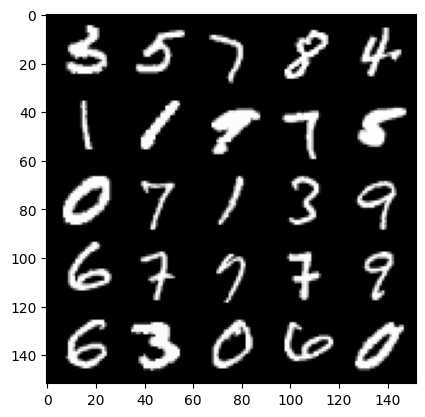

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.7007117708325391, discriminator loss: 0.6971996380090715


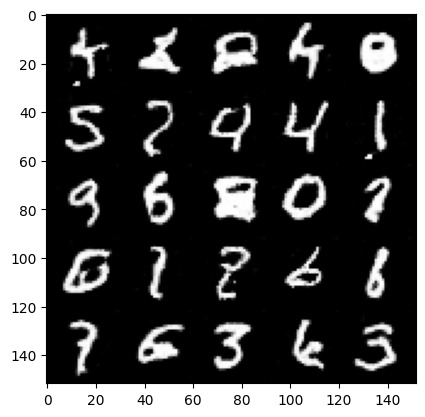

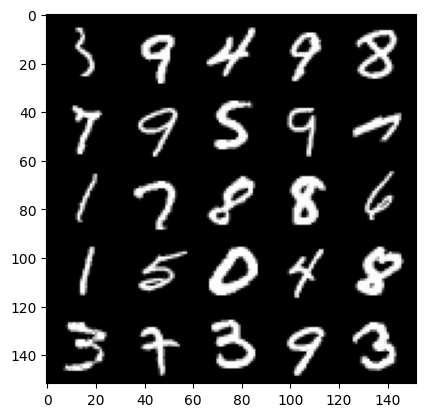

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.6991989377737046, discriminator loss: 0.6979123178720478


In [33]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        
        # Update Discriminator
        disc_opt.zero_grad()
        
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        # keeping track of average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        
        # Update gradients
        disc_loss.backward(retain_graph=True)
        
        # Update Optimizer
        disc_opt.step()
        
        # Update Generator
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()
        
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1